## Entrepreneur Problem

An entrepreneur with volatility $\sigma$ enters the period with $k_t,b_t$, observes the shock $z_{\sigma,t}$ and solves, taking prices as given, the following problem:

$$V_\sigma(k_t,b_t) = \max_{k_{t+1},b_{t+1},c_t,n_t,\phi} \phi \left\{ u(c_t) + \beta E\left[V_\sigma(k_{t+1},b_{t+1}\right]\right\}+(1-\phi)O$$

$$c_t = z_{\sigma,t}k_t^\alpha n_t^{1-\alpha} - w_t n_t +(1-\delta)k_t - b_t $$

Where $O$ is an exogenous outside option.

We can rewrite the problem solving the static labor problem:

$$n^*_t = argmax_{n_t} z_{\sigma,t}k_t^\alpha n_t^{1-\alpha} - w_t n_t +(1-\delta)k_t$$

Taking FOCs and solving for $n$: 
$$ n^*_t = \left(\frac{z_{\sigma,t}(1-\alpha)}{w_t}\right)^{\frac{1}{\alpha}} k_t$$

Define the cash in hand function:
$$X(k_t,b_t,z_{\sigma,t}) := z_{\sigma,t}k_t^\alpha n_t^{* 1-\alpha} - w_t n_t +(1-\delta)k_t - b_t $$
$$ = \left[\left(\frac{z_{\sigma,t}}{w_t}\right)^{\frac{1}{\alpha}}\left(z_{\sigma,t}\left(\frac{z_{\sigma,t}}{w_t}\right)^{1-\alpha} - w_t\right)+1-\delta\right] k_t - b_t =: R(z_{\sigma,t})k_t-b_t$$

The problem above is completely equivalent to the problem of an agent arriving with a given amount of cash each each period:
$$V_\sigma(X_t) = \max_{k_{t+1},b_{t+1},c_t,\phi} \phi \left\{ u(c_t) + \beta E\left[V_\sigma\left(X(k_{t+1},b_{t+1},z_{\sigma,t})\right)\right]\right\}+(1-\phi)O $$

$$c_t = X_t -k_{t+1} + q_\sigma(k_{t+1},b_{t+1})b_{t+1}$$

Under some standard assumptions for the utility function, we know that $V_\sigma$ is increasing therefore $\exists\; \bar{X}$ such that $\forall\,X<\bar{X}$ takes the outside option $O$ and defaults. Given that the support of $z$ is $\mathcal{R}_{++}$ since it follows a lognormal iid distribution, and $X$ is strictly increasing in $z$ we know that:
$$\forall k_{t+1},b_{t+1},\;\exists \;\bar{z},\; st\;\forall z<\bar{z},\;X(k_{t+1},b_{t+1},z_{\sigma,t})<\bar{X} $$

Hence, the default probability is given by $F_\sigma\left(\bar{z}(k_{t+1},b_{t+1})\right)$, where $F_\sigma$ is $z$ cdf with volatility $\sigma$. With this, we can define the bonds pricing function from the financial intermediaries:

$$ q_\sigma(k_{t+1},b_{t+1}) = \frac{1-F_\sigma\left(\bar{z}(k_{t+1},b_{t+1})\right)}{1+r} $$

First, we define some parameters and the Cash in hand grid:

In [1]:
using Distributions,Optim, Interpolations,  FastGaussQuadrature
include("functions.jl")
#Defining Parameters
α = 0.36;    #Capital share of Output
β = 0.9;     #Beta
δ = .025;    #Depreciation rate
σ = .2;      #IID shock volatitily
μ = 1.0;     #1 is log utility, 0 is linear, other parameters is CRRA
r = 0.02;    #Risk free rate
w =  .5;     #Wages (this will be endogenous at some point)
O = 3.0;     #Outside option

#Cash in hand grid:
nX = 1500;          #number of Cash in Hand gridpoints
X = range(-0.0,stop = 30, length = nX);


Now, we define the cash in hand, default probability and bond price functions as explained above:

In [2]:
#Cash in Hands function
x(k,b,z;w=w,δ=δ,α = α) = (z[1]*(1-α)/w)^(1/α)*
k*(z[1]*(z[1]*(1-α)/w)^(1-α)-w)-b+(1-δ)*k;
#Here I solved for n and inputed its functional form

#Defining consumption function:
c(x,k1,b1) = x-k1+q(k1,b1)*b1;

#Defining the Default probability function
DefProb(k1,b1,xbar;σ = σ) = cdf(LogNormal(0.0,σ),
    optimize( z-> abs(xbar - x(k1,b1,z)),eps(),30.0).minimizer);
#finds the probability of z such that X tommorrow is below the threshold xbar 
#as a function of capital and debt choices

q(k1,b1;r=r,σ = σ,xbar = xbar) = (1-DefProb(k1,b1,xbar)) / (1+r);

Guessing an initial level of cash in hands threshold $\bar{X} = 1$. We get that the default probability of taking 1 unit of capital and no debt to the next period is:

In [3]:
xbar = 1.0
#With this guess, default probability of choosing a stock of capital 1 and no debt for tommorow is almost 0:
DefProb(1.0,0.0,xbar)

0.009975618198977089

So debt price is:

In [4]:
#So prices are close to 1
q(1.0,0.0)

0.9706121390206107

Prices are decreasing in debt:

In [5]:
#If the agents decides to bring more debt, q decreases:
q(1.0,1.0)

0.5790091100055929

And increasing in Capital:

In [6]:
q(5.0,0.0)

0.9803623324554014

The code below implements VFI for a given pricing function. 
First, we guess an initial value function and using Tauchen method, we discretize Z to find the expected value function.

In [7]:
#Value function on the grid:
Vgrid = ones(nX).*u.(X);
Vgridf = copy(Vgrid) #This will be used to check convergence;

#Guess for Value function is that grid interpolated linearly:
itp = LinearInterpolation((X),Vgridf, extrapolation_bc=Line());
V(x::Float64) = itp(x);


#Discretize using Tauchen (quadrature could also be used)
integranodes = 30;
weights,nodes = Tauchen(0.0,σ,integranodes);
nodes = exp.(nodes[1,:]);
function EV(k,b,σ;nodes = nodes,weights=weights)
    #find expected value of V using Tauchen discretized process
    expected = 0.0
    for i=1:length(nodes)
        expected += weights[i]*V(x(k,b,nodes[i]))
    end
    return expected
end;

In [8]:
#Function to be maximized by the solver is the usual agent problem in functional form:
function Vf(S,X,σ;β = β)
   k1,b1 = S
   value = u(c(X,k1,b1)) + β * EV(k1,b1,σ)
   return -value
    end;

Now, we go to the VFI loop.

In [14]:
#solver stuff
initial = [.5,.5]
lower = [0.00001,-Inf] #capital is limited below
upper = [Inf,Inf] #Debt and capital are unbounded above
inner_optimizer = BFGS() #Optimization method
#predefining variables and loop stuff
policy = ones(nX,3) #last dimension indicates if it is the policy for k,b,default
iteration =0 #iteration counter
distance = 1.0 #initializing loop
    while distance > 1e-6 
        global policy, Vgrid,Vgridf,initial,iteration,distance,itp
        #the line above is needed only in REPL
        Vgridf = copy(Vgrid) #updated the grid
        for x0 = 1:nX #for each level of cash in hand
            maxV = optimize( s-> Vf(s,X[x0],σ), lower,upper,initial,Fminbox(inner_optimizer))
            #the function above chooses the level of capital and debt that maximizes the value function given cash      
            policy[x0,1:2] = maxV.minimizer
            #saving it to a grid
            if -maxV.minimum >= O #comparing with the outside option
                Vgrid[x0] = -maxV.minimum
                policy[x0,3] =0.0 #No Default
            else
                Vgrid[x0] = O 
                policy[x0,3] = 1.0 #default
            end
            initial = policy[x0,1:2]
        end
        distance = maximum(abs.(Vgrid-Vgridf)) #check grid convergence
        #Update the value function by interpolating the points found above
        itp = LinearInterpolation((X),Vgrid, extrapolation_bc=Line()) 
        V(x::Float64) = itp(x)
    
        iteration += 1
        println("In iteration $(iteration), distance is $(distance)")
    end

In iteration 1, distance is 1.959299802400949e-5
In iteration 2, distance is 0.0


In [15]:
#Finally, find labor, capital and consumption policies with linear interpolation:

itpb = LinearInterpolation((X),policy[:,2], extrapolation_bc=Line())
policy_b(x) = itpb(x)
itpk = LinearInterpolation((X),policy[:,1], extrapolation_bc=Line())
policy_k(x) = itpk(x)
policy_c(x) = c(x,policy_k(x),policy_b(x))
function policy_def(x;O=O)
    if V(x)>=O
        return 0.0
    else
        return 1.0
    end
end

policy_def (generic function with 1 method)

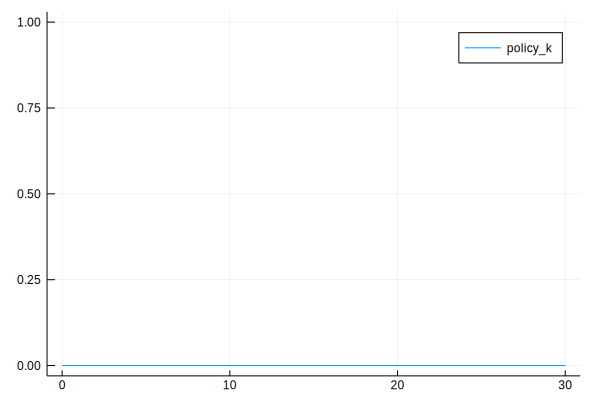

In [16]:
using Plots
plot(X,policy_k.(X), label = "policy_k")

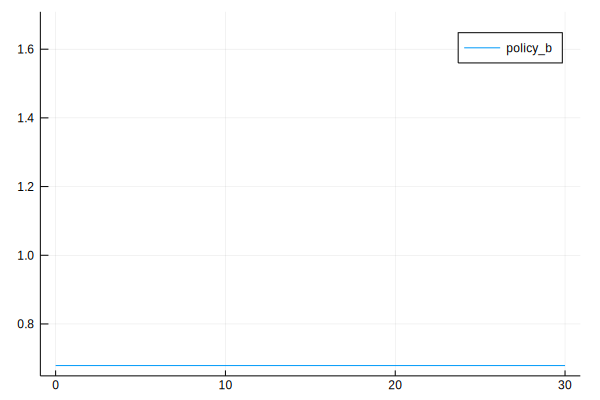

In [17]:
plot(X,policy_b.(X), label = "policy_b")

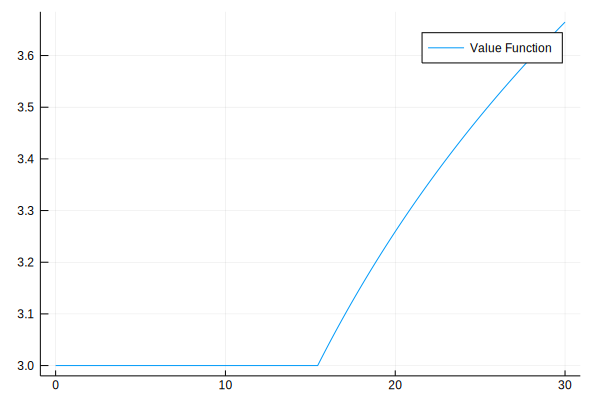

In [18]:
plot(X,V.(X),label = "Value Function")